In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [22]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4
    IMG_HEIGHT:  int = 256
    IMG_WIDTH:   int = 256
    CHANNELS:    int = 3
        
    DATA_ROOT_TRAIN:  str = r"C:\Users\PC\Documents\Dataset_VGGNET16\train"
    DATA_ROOT_TEST:  str = r"C:\Users\PC\Documents\Dataset_VGGNET16\test"
    DATA_ROOT_VALIDACION: str = r"C:\Users\PC\Documents\Dataset_VGGNET16\validacion"


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 20
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8    

In [7]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=32,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALIDACION,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

Found 1264 files belonging to 4 classes.
Found 633 files belonging to 4 classes.
Found 540 files belonging to 4 classes.


In [8]:
print(train_dataset.class_names)

['0', '1', '2', '3']


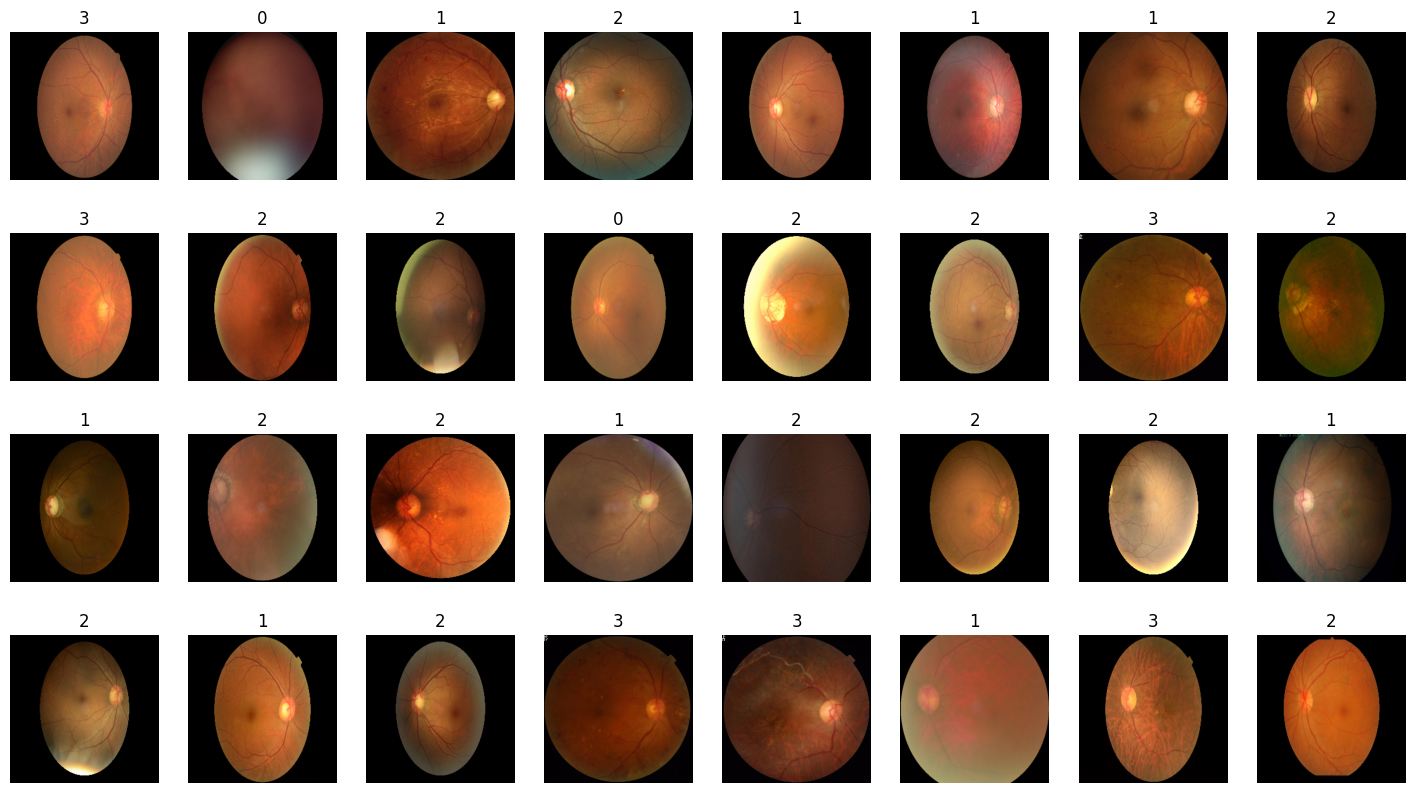

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

num_rows = 4
num_cols = 8

for image_batch, labels_batch in train_dataset.take(1): 
     
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [10]:
class_names_int = list(map(int, train_dataset.class_names))
gtid_2_cnidx = dict(zip(class_names_int, range(0,DatasetConfig.NUM_CLASSES)))
gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (2, 2), (3, 3)])

In [11]:
print('Train/Valid dataset class names: ',train_dataset.class_names)

Train/Valid dataset class names:  ['0', '1', '2', '3']


In [12]:
input_shape = (256, 256, 3)

resnet_conv_base = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                                                           include_top=False,
                                                           weights='imagenet'
                                                          )
print(resnet_conv_base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [13]:
resnet_conv_base.trainable = True

num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(resnet_conv_base.layers)

for model_layer in resnet_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"Congelando capa: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Se entrenan las ultimas", num_layers_fine_tune, "capas")
print("\n")
    
print(resnet_conv_base.summary())

Congelando capa: <keras.engine.input_layer.InputLayer object at 0x000002222D4E26A0>
Congelando capa: <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002222D4E2FA0>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x000002222D5243A0>
Congelando capa: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002222D46F2E0>
Congelando capa: <keras.layers.core.activation.Activation object at 0x000002222D524B80>
Congelando capa: <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002222D551F70>
Congelando capa: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002222D59D280>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x000002222D5A7F40>
Congelando capa: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002222D59D7F0>
Congelando capa: <keras.layers.core.activation.Activation object at 0x000002222D5B93A0>
Congelando capa: <keras.layers.convolu

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 conv1_bn 

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.resnet50.preprocess_input(inputs)
    
x = resnet_conv_base(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
    
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation = 'softmax')(x)
    
model_resnet_finetune = keras.Model(inputs, outputs)

print(model_resnet_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               167773

In [16]:
model_resnet_finetune.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = TrainingConfig.LEARNING_RATE),
                              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                              metrics = ['accuracy']
                             )

In [17]:
training_results = model_resnet_finetune.fit(train_dataset,
                                             epochs = TrainingConfig.EPOCHS,
                                             validation_data = valid_dataset
                                            )

Epoch 1/20
40/40 [==============================] - 126s 3s/step - loss: 1.7264 - accuracy: 0.5570 - val_loss: 0.7343 - val_accuracy: 0.7251
Epoch 2/20
40/40 [==============================] - 120s 3s/step - loss: 0.8279 - accuracy: 0.6685 - val_loss: 0.6760 - val_accuracy: 0.7141
Epoch 3/20
40/40 [==============================] - 120s 3s/step - loss: 0.7086 - accuracy: 0.7128 - val_loss: 0.6083 - val_accuracy: 0.7741
Epoch 4/20
40/40 [==============================] - 120s 3s/step - loss: 0.6460 - accuracy: 0.7278 - val_loss: 0.6060 - val_accuracy: 0.7709
Epoch 5/20
40/40 [==============================] - 120s 3s/step - loss: 0.5980 - accuracy: 0.7445 - val_loss: 0.5974 - val_accuracy: 0.7741
Epoch 6/20
40/40 [==============================] - 120s 3s/step - loss: 0.5140 - accuracy: 0.7801 - val_loss: 0.5773 - val_accuracy: 0.7709
Epoch 7/20
40/40 [==============================] - 120s 3s/step - loss: 0.4846 - accuracy: 0.7991 - val_loss: 0.6115 - val_accuracy: 0.7852
Epoch 8/20
40

In [18]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

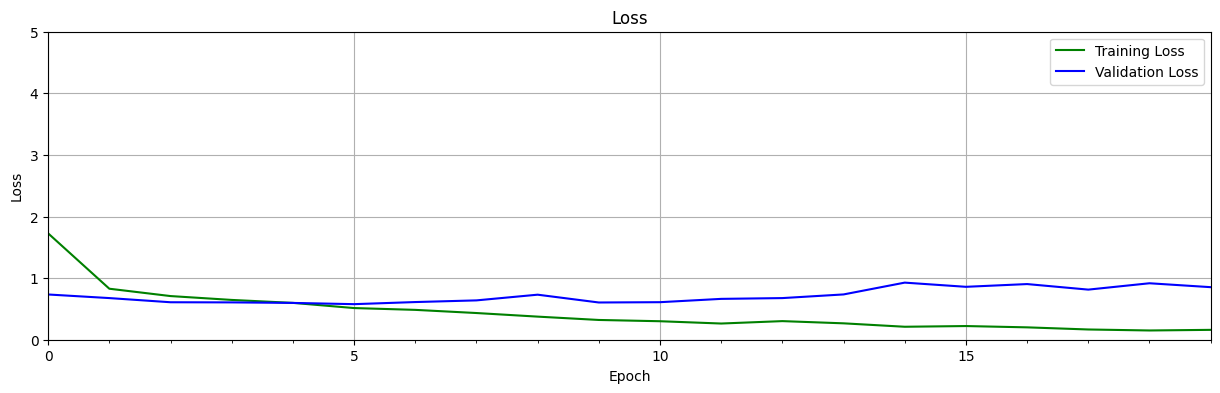

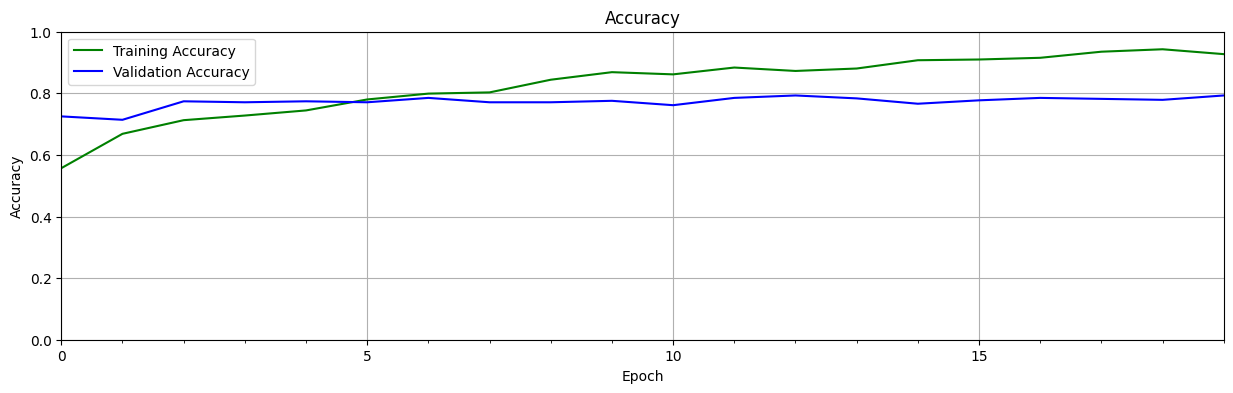

In [19]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [23]:
print(f"Test accuracy: {model_resnet_finetune.evaluate(test_dataset)[1]*100.:.3f}")

17/17 [==============================] - 34s 2s/step - loss: 1.0783 - accuracy: 0.7519
Test accuracy: 75.185


In [24]:
def display_predictions(dataset, model, class_names):
    
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
    
    for image_batch, labels_batch in dataset.take(2):
        
        print(image_batch.shape)
        
        predictions = model.predict(image_batch)
        
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()
            
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                
            jdx += 1
                
            if jdx > num_rows*num_cols:
                break
                
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])
                
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return 

(32, 256, 256, 3)
1/1 [==============================] - 2s 2s/step
(32, 256, 256, 3)
1/1 [==============================] - 2s 2s/step


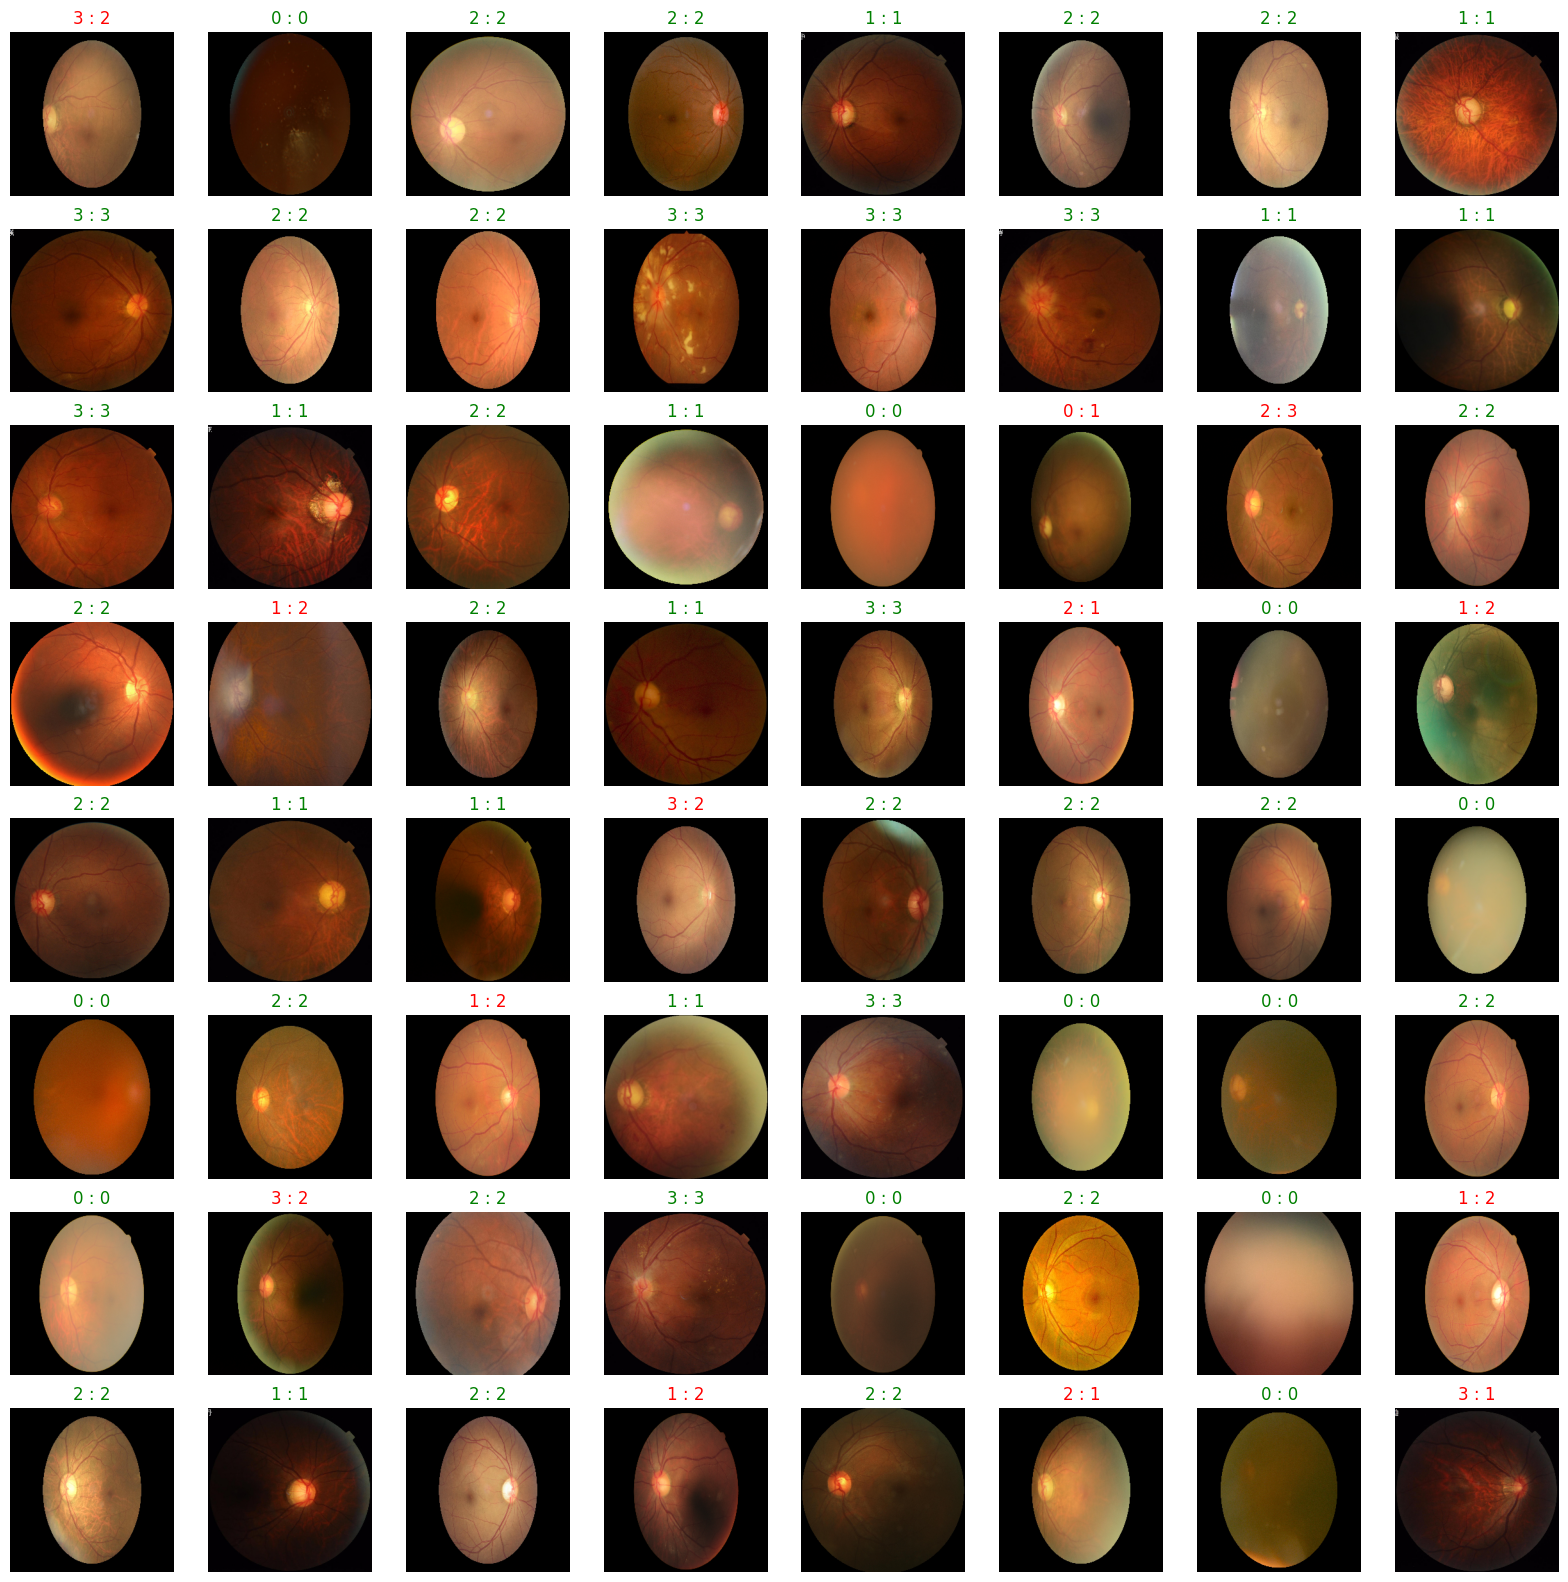

In [25]:
display_predictions(test_dataset, model_resnet_finetune, class_names)